# Movie Recommendation System with Content Filtering and Bechdel Sorting

#### Rationale:
<p>Modern movie recommendation systems use an optimised mix of content filtering, matrix factorization and clustering to offer relevant products. These recommendation systes are anchored in a feedback loop with users providing ratings and feedback with consumption metadata (e.g. hours watched, "added to list" flag etc) </p>
<p> My model uses content filtering using natural language filtering to find similarities between movies using plot synopsis, genre and cast. The heuristic argues that a movie by Tarantino about gangs and heists is likely to be similar to movies about con jobs and seedy underbellies. We meaure this using the cosine similarity co-efficient. 
<p> However, when presenting these recommendations to end-users, ideally user rankings, user biases and movie rankings would be factored in. The premise is users inherently demand the most relevant content without having to venture into the long-tails of recommendations systems - where content is similar but less relevant to the user (see graph below). I will be using a mix of Bechdel ranking and average movie IMDb ranking to sort the recommendation list. 
    
The Bechdel Rank is a factorized (0 to 3) take on the classic binary Bechdel test that whether a movie has</p>
    <li>i] two named female characters; </li>
    <li>ii] who have a conversation with each other;</li> 
    <li>iii] about something other than a man or men.</li> 
<p>The test is a simple litmus test of the representation of women in fiction as pure plot devices or meaningful roles with developed character arcs. More nuanced intersectional tests have since been suggested which factor more than a binary gender identification, but for sake of simiplicity, we will pursue the original definition. </p>

#### Objectives:    
<ol>- Identify key methods used for recommendation systems. </ol>
<ol>- Create a recommendation system with content filtering.</ol>
<ol>- Use a hybrid of Bechdel score and IMDb user rating to present top 5 movie recommendations.</ol></li>


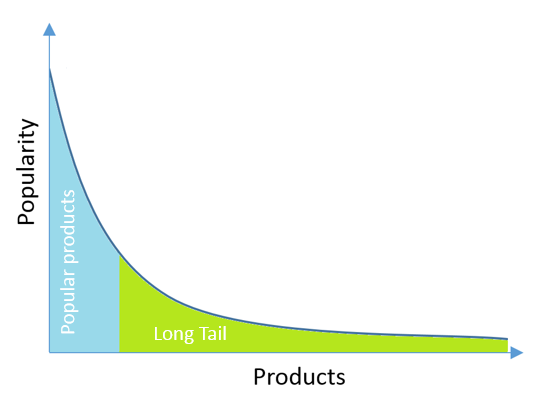

src: https://medium.com/@kyasar.mail/recommender-systems-what-long-tail-tells-91680f10a5b2

#### Sparsity and long-tail are 2 important properties of a recommender system to take into account in design and process

### 1a. Import Boilerplate code

In [498]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [499]:
from surprise import Dataset
from surprise import SVD    
from surprise.model_selection import cross_validate
#SVD Singular Value Decomposition

### 1b. The Data

<p>The first data source is from the Bechdel Test API and is user submitted rank. This can often be subjective and has long sleuth of discussion on each rating. The online db has 8440 movie on last check - this is a known limitation.</p>

In [500]:
import requests # a library that lets us make HTTP requests

bechdel_api_url = 'http://bechdeltest.com/api/v1/getAllMovies?none' #params'+date_str
bechdel_response = requests.get(bechdel_api_url) # make a request to the URL
bechdel_response.status_code # this tells us whether the request was successful

200

In [501]:
bechdel_json=bechdel_response.json()
len(bechdel_json)

8440

In [502]:
bechdel_json[80]

{'title': 'When the Clouds Roll by',
 'year': 1919,
 'id': 2018,
 'rating': 3,
 'imdbid': '0010879'}

In [503]:
bechdel_df = pd.DataFrame(columns=['title','imdbid','rating','id','year'])

,title,imdbid,rating,id,year


In [504]:
for movie in bechdel_json:
    bechdel_df=bechdel_df.append(movie,ignore_index=True)

In [505]:
bechdel_df.head()

,title,imdbid,rating,id,year
0,Roundhay Garden Scene,0392728,0,8040,1888
1,Pauvre Pierrot,0000003,0,5433,1892
2,Tables Turned on the Gardener,0000014,0,5444,1895
3,"Execution of Mary, Queen of Scots, The",0132134,0,6200,1895
4,"House of the Devil, The",0000091,0,4982,1896


In [506]:
bechdel_df.describe()

,title,imdbid,rating,id,year
count,8440,8440,8440,8440,8440
unique,8246,8435,4,8440,126
top,Dracula,2457282,3,9060,2013
freq,4,2,4871,1,406


<p> The second data source is an open data source from Kaggle which has the plot synopsis and genre. We will merge these using the imdb id as a primary key.</p>
<a href=https://www.kaggle.com/rmisra/imdb-spoiler-dataset>https://www.kaggle.com/rmisra/imdb-spoiler-dataset</a>

In [507]:
movies_imdb= pd.read_json('IMDB_movie_details.json',lines=True)

In [508]:
#there is a prefix on the imdb id field that we will strip out any non-numeric characters
def custom_str(x):
    if x.isnumeric():
        return True
    else:
        return False
print("".join(filter(custom_str,[l for l in "tt0114142/"])))

0114142


In [509]:
def stripper_func(stringything):
    return(("".join(filter(custom_str,[l for l in stringything]))))

In [510]:
movies_imdb['movie_id_new']=movies_imdb.movie_id.apply(lambda x: stripper_func(x))

In [512]:
movies_imdb.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis,movie_id_new
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",0105112
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...,1204975
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,,0243655
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...,0040897
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...,0126886


In [513]:
combined_df=pd.merge(bechdel_df,movies_imdb,left_on='imdbid',right_on='movie_id_new')

<p> A third and final data set is a cleaned up and merged dataset from another kaggle source. This contains metadata about the keywords and cast. </p>
<a href=https://www.kaggle.com/rounakbanik/the-movies-dataset> https://www.kaggle.com/rounakbanik/the-movies-dataset </a>

In [516]:
new_df=pd.read_csv('more_data.csv',dtype={'imdbId':object})
new_df.columns

Index(['Unnamed: 0', 'movieId', 'imdbId', 'tmdbId', 'cast', 'crew', 'id'], dtype='object')

In [517]:
combined_df.dtypes

title             object
imdbid            object
rating_x          object
id                object
year              object
movie_id          object
plot_summary      object
duration          object
genre             object
rating_y         float64
release_date      object
plot_synopsis     object
movie_id_new      object
dtype: object

In [518]:
combined_df1=pd.merge(combined_df,new_df,left_on='imdbid',right_on='imdbId')

In [519]:
print("bechdel: "+str(bechdel_df.shape)+", movies_df:"+str(movies_imdb.shape)+", combined:"+str(combined_df.shape)+ ", combined1:"+str(combined_df1.shape))

bechdel: (8440, 5), movies_df:(1572, 8), combined:(1331, 13), combined1:(419, 20)


It is disheartening to see the data loss. Denser data will improve the pool of movies and content matching. But since this is not fundamental to the proof of concept, we match on.

In [520]:
combined_df1['cast_str']=combined_df1.cast.astype('str')
combined_df1["genre_str"]=combined_df1.genre.astype('str')

In [522]:
features = ['plot_summary','plot_synopsis','genre_str','cast_str']
# I will add "keywords" feature later.

In [523]:
for feature in features:
    combined_df1[feature] = combined_df1[feature].fillna('') #filling all NaNs with blank string

In [524]:
def combine_features(row):
    return row['plot_summary']+" "+str(row['cast_str'])+" "+row['genre_str']+" "+row['plot_synopsis']

combined_df1["combined_features"] = combined_df1.apply(combine_features,axis=1) #applying combined_features() method over each rows of dataframe and storing the combined string in "combined_features" column

### 2. The Model

In [525]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer

In [526]:
lemma = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (lemma.lemmatize(w) for w in analyzer(doc))


In [527]:
cv1 = CountVectorizer(analyzer=stemmed_words,lowercase=True, stop_words='english', ngram_range=(1,2))
#cv1.get_stop_words()

In [528]:
count_matrix = cv1.fit_transform(combined_df1["combined_features"]) #feeding combined strings(movie contents) to CountVectorizer() object

In [583]:
viewsparse  = pd.DataFrame(count_matrix.todense(),
             columns=cv1.get_feature_names())
#viewsparse.sum()

In [582]:
#cv1.get_feature_names()[:20]

In [585]:
#viewsparse.sum().sort_values(ascending=False)[:20]

#### This already looks promising since the genres will result in high degree of similarity

In [532]:
cosine_sim = cosine_similarity(count_matrix)

In [534]:
print(cosine_sim.shape)
cosine_sim

(419, 419)


array([[1.        , 0.84900068, 0.84679541, ..., 0.79609765, 0.81555517,
        0.79293672],
       [0.84900068, 1.        , 0.84025033, ..., 0.75174938, 0.74123303,
        0.73712587],
       [0.84679541, 0.84025033, 1.        , ..., 0.74062705, 0.74451676,
        0.76541748],
       ...,
       [0.79609765, 0.75174938, 0.74062705, ..., 1.        , 0.875768  ,
        0.82452337],
       [0.81555517, 0.74123303, 0.74451676, ..., 0.875768  , 1.        ,
        0.82617562],
       [0.79293672, 0.73712587, 0.76541748, ..., 0.82452337, 0.82617562,
        1.        ]])

In [535]:
#two helper functions to get movie title from movie index and vice versa
def get_title_from_index(index):
    return combined_df1[combined_df1.index==index]['title'].values[0]

def get_index_from_title(title):
    return combined_df1[combined_df1.title==title].index.values[0]

In [536]:
#random movie generator
import random
print(random.randint(0,combined_df1.shape[0]))

393


In [571]:
#random_movie = get_title_from_index(random.randint(0,combined_df1.shape[0]))
#print(random_movie)
movie_user_likes = "Little Women"
movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index]))

In [572]:
sorted_similar_movies = sorted(similar_movies, key =lambda x:x[1],reverse=True)[1:6]

In [573]:
i = 0
print("Top 5 similar movies to "+movie_user_likes+" are:\n")
for element in sorted_similar_movies:
    print(get_title_from_index(element[0]))
    i=i+1
    if i>5:
        break

Top 5 similar movies to Little Women are:

Fly Away Home
Wild
Amelie
V for Vendetta
Hard Candy


#### Factoring in Bechdel rank and average user vote to influence the sorting of the list. However, note that this is still not factoring in personal user ratings and biases

In [586]:
#sort_by_average_vote= sorted(sorted_similar_movies, key=lambda x:combined_df1['rating_y'][x[0]], reverse=True)
#print(sort_by_average_vote)

In [575]:
sort_by_bechdel_average_vote= sorted(sorted_similar_movies, key=lambda x:(combined_df1['rating_x'][x[0]],combined_df1['rating_y'][x[0]]), reverse=True)
#print(sort_by_average_vote)
#rating_x is Bechdel and rating_y is imdb rating

In [587]:
i=0
print("Suggesting top 5 movies in order of Bechdel rank and Average Votes:\n")
for element in sort_by_bechdel_average_vote:
    print(get_title_from_index(element[0]))
    i=i+1
    if i>5:
        break

Suggesting top 5 movies in order of Bechdel rank and Average Votes:

Amelie
V for Vendetta
Wild
Hard Candy
Fly Away Home


In [588]:
#sort first by bechdel, then by user rating, then by cosine similarity
#combined_df1.iloc[get_index_from_title("Suicide Squad")]

Next steps would be to use SVD, unsupervised learning and clean the NLP data and try different methods to vectorise the text content.